# Sentiment Analysis and Topic Modelling of COVID-19 Tweets: Unveiling Changes in Sentiments and Major Topics in the U.S. during Early 2020

## Introduction
During times of the COVID-19 pandemic, Twitter has emerged as a powerful medium for individuals to share their real-time thoughts, concerns, and experiences. Some practical methods of gaining valuable insights and situation-consciousness in a specific stage of the pandemic include analyzing the sentiments expressed and topics emerged in timely tweets. In this study, we aim to conduct sentiment analysis and topic modelling on a dataset of tweets that are from March 2nd to April 20th 2020 and related to COVID-19. Specifically, we focus on Twitter users who are self-identified as located in the United States and seek to address two primary research questions below.

## Research Questions
**Research Question 1:**
What was the prevailing sentiment of Twitter users in the United States in the first months of COVID-19 outbreak, and how did it change?

This research question seeks to investigate the sentiment dynamics among U.S. Twitter users during the initial months of the COVID-19 outbreak. The tweets will be subjected to sentiment analysis, employing natural language processing techniques to extract sentiment scores associated with each tweet, and also be visuallized to show its day-to-day trend. Analyzing how the sentiment changes with time trends provides us insights into the U.S. people’s prevailing sentiment of the pandemic at its very beginning, gauging the impact of public health crises on public opinion.

**Research Question 2:**
What were the major topics about COVID-19 Twitter users in the United States discussing during early 2020, and how are the topics related to each other?

This question aims to identify and explore the major topics of discussion among U.S. Twitter users during the initial months of the COVID-19 outbreak. By employing topic modelling, we identify topics that garnered significant attention and engagement from Twitter users. Then, we reveal connections between different topics by visualizing and observing patterns and groupings among the topics. This analysis would enable an understanding of timely concerns of the U.S. people, aiding in comprehending public needs, identifying information gaps, and so on.

## Install packages and import libraries

In [1]:
#install packages
!pip install nltk 
!pip install plotly
!pip install scikit-learn
!pip install -U textblob
!pip install bokeh
!pip install networkx
!pip install wordcloud

In [2]:
# Import libraries

# Data manipulation
import pandas as pd 
import numpy as np
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from wordcloud import WordCloud

# NLP
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
import string
import re

# Analysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Description
This dataset is named 'Coronavirus tweets NLP - Text Classification' downloaded from https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification. 

The dataset contains 6 columns and 44955 rows of information about the tweets from March 2nd to April 20th 2020 during COVID-19. The columns and their descriptions are: 
1. UserName:       int64.  The masked users' real names as a sequence of user id's starts from 1 increments by 1
2. ScreenName:     int64.  The masked users' usernames as a sequence of user id's starts from 45593 increments by 1
3. Location:       String. User input tweet locations
4. TweetAt:        String. Tweet posted date in the format of dd-mm-yyyy
5. OriginalTweet:  String. The tweet content.
6. Sentiment:      String. Sentiment labeled by unkown methods (Extremely Negative, Negative, Neutural, Positive, Extremely Positive).


In [3]:
# Read the CSV files into separate DataFrames
test_df = pd.read_csv('Corona_NLP_test.csv', encoding="latin1")
train_df = pd.read_csv('Corona_NLP_train.csv', encoding="latin1")

# Concatenate the DataFrames vertically with unique user id's because we are not doing modeling for this project
df = pd.concat([test_df, train_df]).drop_duplicates('UserName').reset_index(drop=True)

In [4]:
# The dataset size
print(df.shape)

(44955, 6)


In [5]:
# Take a look at the first 5 rows
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
# Statistical summary of the dataset
df.describe(include='object')

,Location,TweetAt,OriginalTweet,Sentiment
count,35531,44955,44955,44955
unique,13127,44,44955,5
top,United States,20-03-2020,TRENDING: New Yorkers encounter empty supermar...,Positive
freq,603,3448,1,12369


_We can see that there are 44955 rows for all other columns but only 35531 for location, which indicates there are missing locations that we will drop in data preprocessing. Also, we have noted that the U.S. has only appeared 603 times but is the most appeared location, which means the data may not be in a unified format. The range of days that are included in this data set is 44, but 20-03-2020 has appeared for about 1/13 of the observations._

## Data Preprocessing


In [7]:
# Take a look at the missing value
df.isna().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [8]:
# Drop the missing value
df.dropna(inplace=True)
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

In [9]:
#filter data related to the United States

#define expression
usa_names = ['usa', 'united states'] #define a list of possible names used to represent the United States

state_names = ['alabama', 'alaska', 'arizona', 'arkansas', 'california', 'colorado', 'connecticut', 'delaware',
              'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky','louisiana', 
               'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi','missouri', 'montana', 
               'nebraska', 'nevada', 'new hampshire', 'new jersey', 'new mexico', 'new york', 'north carolina', 
               'north dakota', 'ohio', 'oklahoma', 'oregon', 'pennsylvania','rhode island', 'south carolina', 
               'south dakota', 'tennessee', 'texas', 'utah', 'vermont','virginia', 'washington', 'west virginia', 
               'wisconsin', 'wyoming'] #define a list of possible names used to represent states

possib_names = r'\b(?:{})\b'.format('|'.join(usa_names + state_names)) #concatenate lists

possib_abvs = ['US','AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 
               'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 
               'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC','SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 
               'WV', 'WI', 'WY'] #define a list of possible abbreviations of states

possib_abvs_1 = r'\b(?:{})\b'.format('|'.join(possib_abvs)) #create a word boundary and non-capturing group in the regular expression pattern


_Since the locations in the dataset are user-defined, we filter them with lists of related expressions. A special note is that since the state abbreviations such as "IN" or "ME" can lead to ambiguity in lowercase, possib_abvs was created to be matched with the original column "Location" to obtain cleaner data._

In [10]:
#match data to expression
df['Location_lower'] = df['Location'].str.lower() #assign a lowercase version of 'Location' 

filtered_names = df['Location_lower'].str.contains(possib_names, regex=True)
filtered_abvs = df['Location'].str.contains(possib_abvs_1, regex=True)
filtered_users = filtered_names | filtered_abvs #find the union of filtered_names and filtered_abvs

df = df[filtered_users]
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Location_lower
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,"seattle, wa"
12,13,44965,"USA, PA",04-03-2020,Panic food buying in Germany due to #coronavir...,Extremely Negative,"usa, pa"
14,15,44967,"Washington, DC",04-03-2020,While we were busy watching election returns a...,Positive,"washington, dc"
21,22,44974,"Texas, USA",05-03-2020,For those of you that think credit/debit is ju...,Extremely Positive,"texas, usa"
22,23,44975,"Florida, USA",06-03-2020,Control over stocks and gold is lost...gold co...,Extremely Positive,"florida, usa"
...,...,...,...,...,...,...,...
44934,44935,89887,"Pasadena, CA",14-04-2020,How COVID-19 Has Impacted How Consumers Spend ...,Neutral,"pasadena, ca"
44936,44937,89889,"Los Angeles, CA",14-04-2020,HMU FOR PRICES!! Got great deals going right n...,Extremely Positive,"los angeles, ca"
44943,44944,89896,"Manhattan, NY",14-04-2020,How exactly are we going to re-open New York C...,Positive,"manhattan, ny"
44945,44946,89898,"Brooklyn, NY",14-04-2020,YÂall really shitting that much more at home?...,Negative,"brooklyn, ny"


In [11]:
# Text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove RT (retweet sign)
    text = re.sub(r'rt[\s]+', '', text)
    # Remove mentions
    text = re.sub(r'@\S+', '', text)
    # Remove all non-alphabetic characters and non-whitespace characters
    text = re.sub(r'[^\w\s]|_', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove leading and trailing whitespaces
    text = text.strip()
    # Replace "covid 19" with "covid19"
    text = re.sub(r'covid\s*19', 'covid19', text)
    # Remove stopwords
    text = " ".join([i for i in text.split() if i not in stop_words])
    return text

df['CleanTweet'] = df['OriginalTweet'].apply(clean_text)

In [12]:
# Take a look at the cleaning
pd.set_option('display.max_colwidth', None)
df[["OriginalTweet","CleanTweet"]].head(3)

,OriginalTweet,CleanTweet
1,"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how #coronavirus concerns are driving up prices. https://t.co/ygbipBflMY",find hand sanitizer fred meyer turned amazon 114 97 2 pack purell check coronavirus concerns driving prices
12,"Panic food buying in Germany due to #coronavirus has begun. But the #organic is left behind! #Hamsterkauf\r\r\n\r\r\nPanic buying is called ""Hamster purchases""(HamsterkÃ¤ufe) in German, taken from the way Hamsters stuff their cheeks with food. \r\r\n\r\r\nhttps://t.co/aYQtLLGW1m",panic food buying germany due coronavirus begun organic left behind hamsterkauf panic buying called hamster purchases hamsterkã ufe german taken way hamsters stuff cheeks food
14,"While we were busy watching election returns and bracing for a Covid-19 outbreak, Trump nominated a chemical-industry lobbyist to head the Consumer Product Safety Commission https://t.co/M2ShHI1Tn0",busy watching election returns bracing covid19 outbreak trump nominated chemical industry lobbyist head consumer product safety commission


### 1. Sentiment Analysis

_First use SentimentIntensityAnalyzer() from nltk to get sentiment scores._

In [13]:
sia = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['CleanTweet'].apply(lambda x: sia.polarity_scores(x))
df['sentiment_scores'].head()

1      {'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'compound': 0.5994}
12     {'neg': 0.223, 'neu': 0.777, 'pos': 0.0, 'compound': -0.765}
14     {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.4215}
21     {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'compound': 0.6705}
22    {'neg': 0.122, 'neu': 0.66, 'pos': 0.218, 'compound': 0.5994}
Name: sentiment_scores, dtype: object

Let's draw a **Diverging Bar Chart** to visualize the distribution of positive and negative sentiment score(probability) each day.

In [14]:
#create 4 columns 'pos', 'neg', 'neu', 'compound' from the sentiment_scores dictionary
df[['neg', 'neu', 'pos', 'compound']] = df['sentiment_scores'].apply(pd.Series)

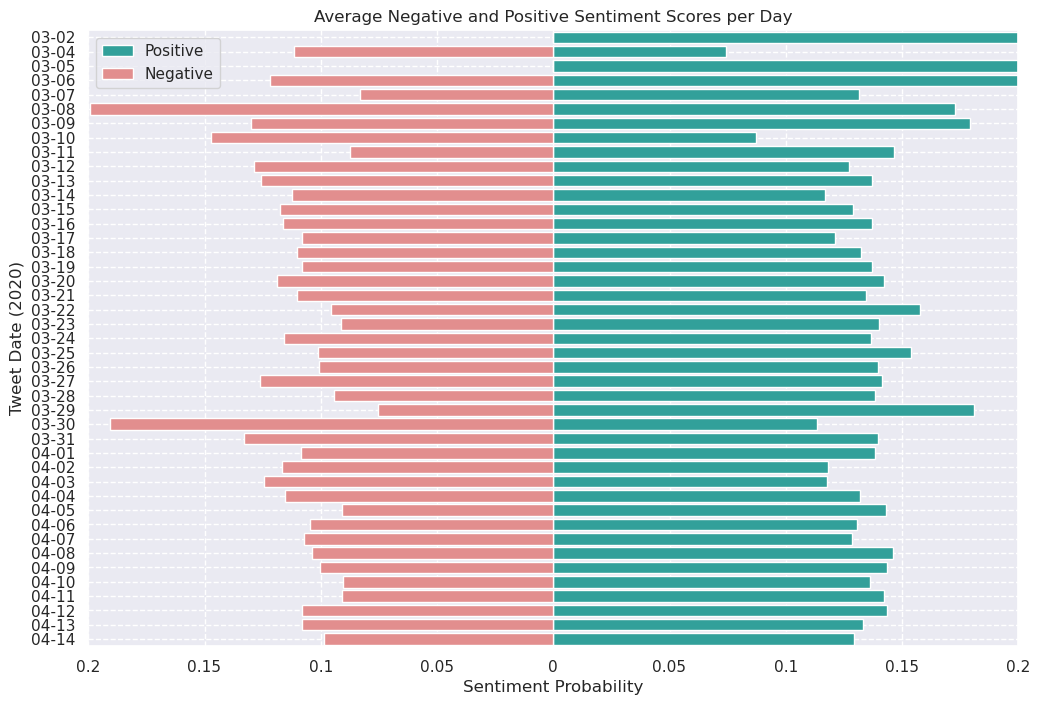

In [15]:
# Calculate the average negative and positive scores for each day
daily_avg_scores = df.groupby('TweetAt')[['neg', 'pos', 'compound']].mean()

# Convert the index of daily_avg_scores (TweetAt) to datetime format in order to sort correctly
daily_avg_scores.index = pd.to_datetime(daily_avg_scores.index, format='%d-%m-%Y')
daily_avg_scores = daily_avg_scores.sort_index()

# Create the Diverging Bar Chart
sns.set(style='darkgrid')
plt.figure(figsize=(12, 8))
sns.barplot(x=daily_avg_scores['pos'], y=daily_avg_scores.index.strftime('%m-%d'), color='lightseagreen', label='Positive')
sns.barplot(x=-daily_avg_scores['neg'], y=daily_avg_scores.index.strftime('%m-%d'), color='lightcoral', label='Negative')
plt.xlabel('Sentiment Probability')
plt.ylabel('Tweet Date (2020)')
plt.title('Average Negative and Positive Sentiment Scores per Day')
plt.legend()
plt.grid(linestyle='--')
plt.xlim(-0.2, 0.2)
plt.xticks([-0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2], [0.2, 0.15, 0.1, 0.05, 0, 0.05, 0.1, 0.15, 0.2])

plt.show()

In [16]:
# Calculate the percentage that positive sentiment probability is greater than negative sentiment probability.
np.mean(daily_avg_scores['pos'] > daily_avg_scores['neg'])

0.8604651162790697

_We see that positive sentiment probability outweighs negative sentiment probability for 86.05% of the time._

_Now let's find the trend by using the compound sentiment scores. But before that, we should check the distribution of data with respect to time._

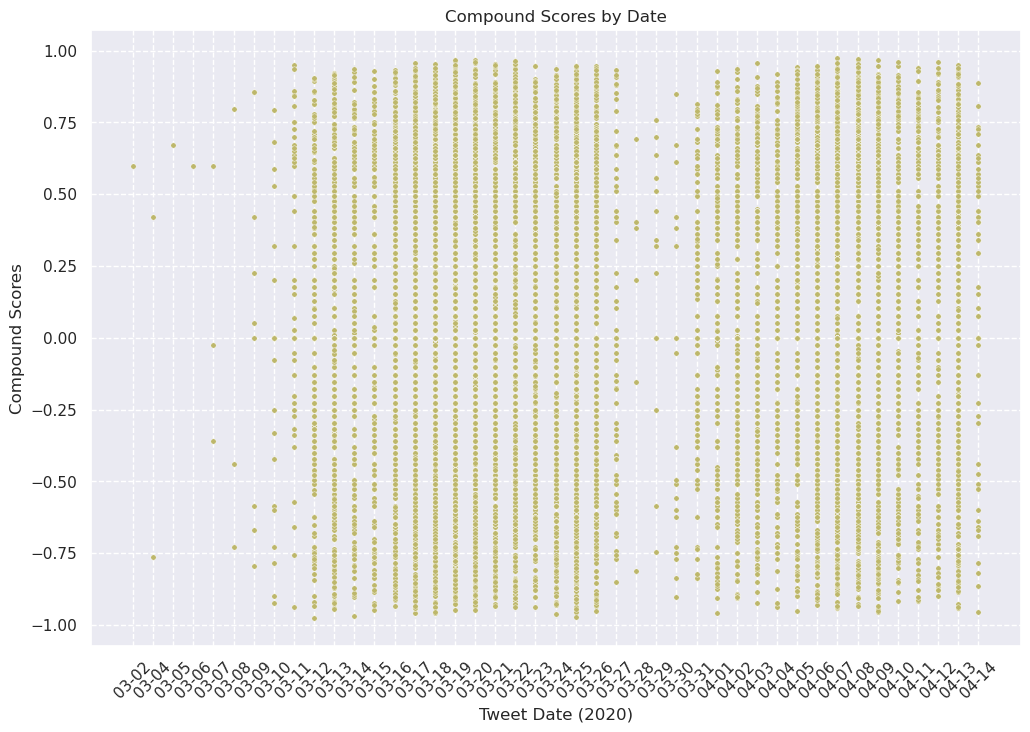

In [17]:
# Convert TweetAt to datetime format in order to sort correctly
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

# Create the scatter plot for compound scores
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df['TweetAt'].dt.strftime('%m-%d'), y=df['sentiment_scores'].apply(lambda x: x['compound']), color='darkkhaki', s=15)
plt.xlabel('Tweet Date (2020)')
plt.ylabel('Compound Scores')
plt.title('Compound Scores by Date')
plt.xticks(rotation=45)
plt.grid(linestyle='--')
plt.show()

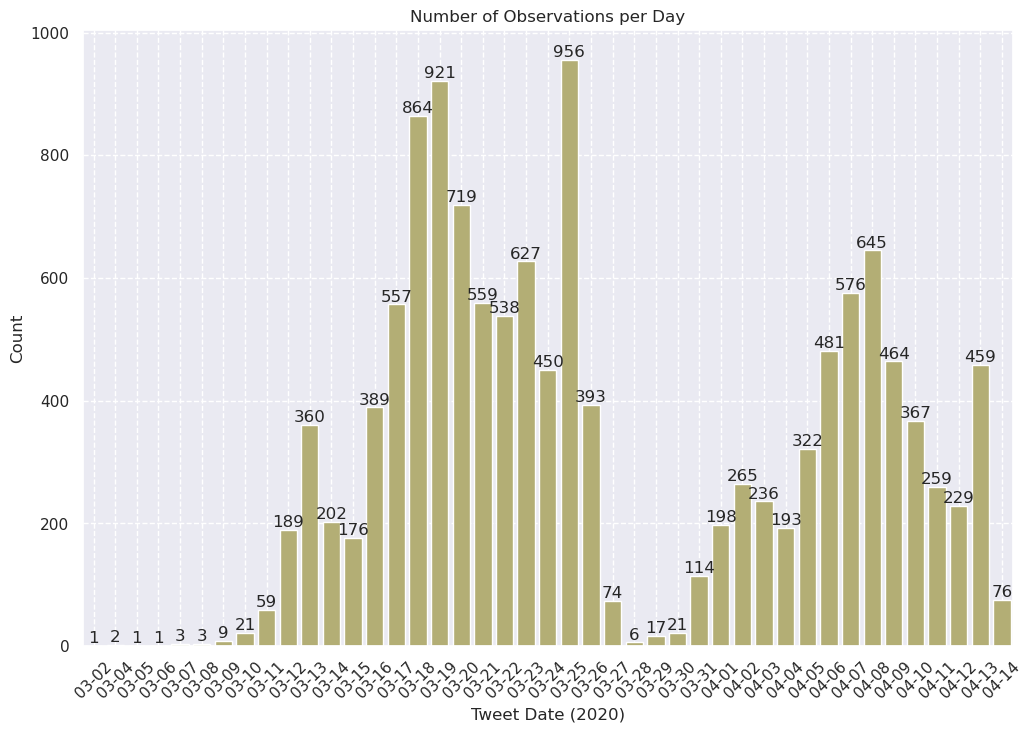

In [18]:
# Count the number of observations per day
daily_counts = df['TweetAt'].value_counts().sort_index()

# Create the bar Chart, here we use the same dates as before
plt.figure(figsize=(12, 8))
sns.barplot(x=daily_avg_scores.index.strftime('%m-%d'), y=daily_counts, color='darkkhaki')

# Add numbers on each bar
for i, count in enumerate(daily_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.xlabel('Tweet Date (2020)')
plt.ylabel('Count')
plt.title('Number of Observations per Day')
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--')
plt.show()

_We see that the distribution is very inconsistent. We could use two linear regression at for the two clusters to fit the compound scores. Looking at the graph, we will use 03/29 as the separator.df['TweetAt']_

In [19]:
#creating subsets
subset1 = df[df['TweetAt'] <= datetime(2020, 3, 29)]
subset2 = df[df['TweetAt'] > datetime(2020, 3, 29)]

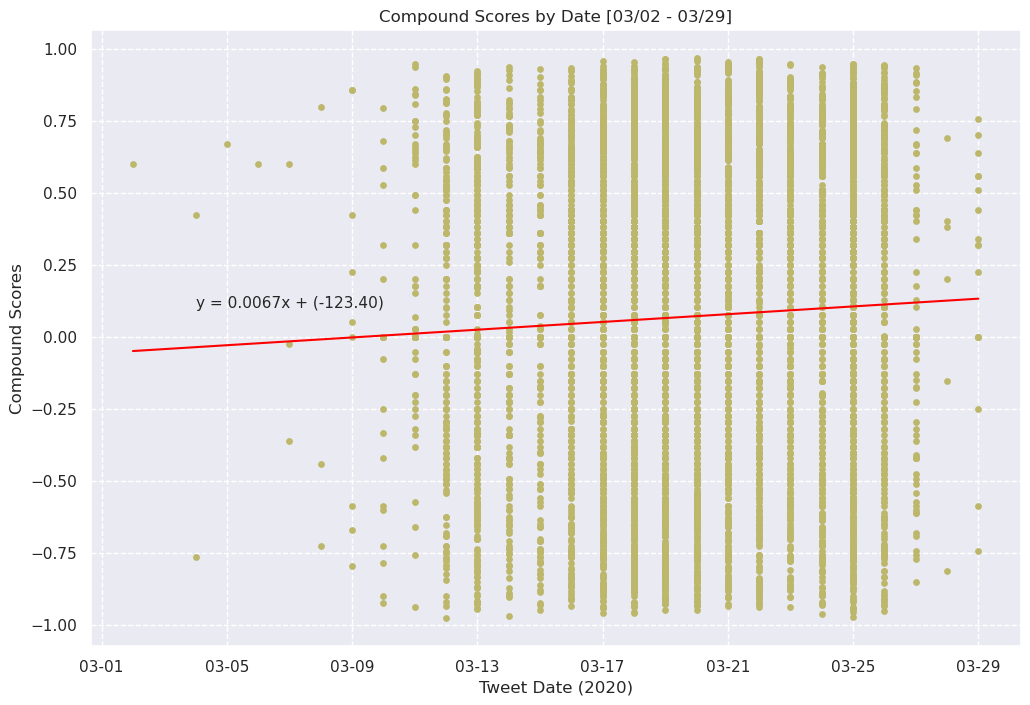

In [20]:
# Plot best fit line for subset1
# Convert 'TweetAt' to pydatetime in order to use the correct labels
x = subset1['TweetAt'].dt.to_pydatetime()
y = subset1['compound']

# Find line of best fit, here we need to use numeric x values
a, b = np.polyfit(mdates.date2num(x), y, 1)

# Create the scatterplot
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color = 'darkkhaki', s = 15)

# Add best fit line
plt.plot(x, a * mdates.date2num(x) + b, color = 'red')

# Label the x-axis as the original dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Label the x-axis
plt.xlabel('Tweet Date (2020)')
plt.ylabel('Compound Scores')
plt.title('Compound Scores by Date [03/02 - 03/29]')
plt.grid(linestyle='--')

# Add slope-intercept equation
equation = 'y = ' + '{:.4f}'.format(a) + 'x + ' + '({:.2f})'.format(b)
plt.text(x[1], 0.1, equation, size=11)

# Show the plot
plt.show()

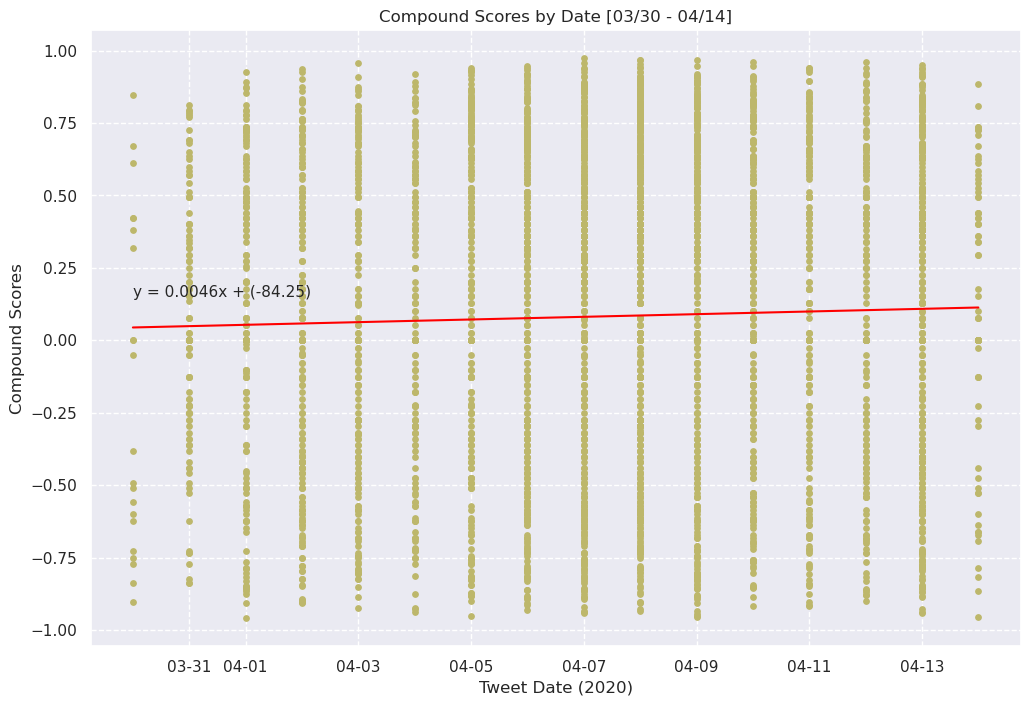

In [21]:
# Plot best fit line for subset2
# Convert 'TweetAt' to pydatetime in order to use the correct labels
x = subset2['TweetAt'].dt.to_pydatetime()
y = subset2['compound']

# Find line of best fit, here we need to use numeric x values
a, b = np.polyfit(mdates.date2num(x), y, 1)

# Create the scatterplot
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color = 'darkkhaki', s = 15)

# Add best fit line
plt.plot(x, a * mdates.date2num(x) + b, color = 'red')

# Label the x-axis as the original dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Label the x-axis
plt.xlabel('Tweet Date (2020)')
plt.ylabel('Compound Scores')
plt.title('Compound Scores by Date [03/30 - 04/14]')
plt.grid(linestyle='--')

# Add slope-intercept equation
equation = 'y = ' + '{:.4f}'.format(a) + 'x + ' + '({:.2f})'.format(b)
plt.text(x[1], 0.15, equation, size=11)

# Show the plot
plt.show()

_From the best fit lines, we can see that there are upward trends for the two groups, implying that as time went by, the tweets tend to be more positive. The second group has a higher intercept but a gentler slope than the first one, indicating a general upward trend and more stability for the whole set of compound scores. Although the small slopes may seem insignificant, note that the y axis has a very small range. By t-test calculator, they are indeed significant._

### 2. Topic Analysis

In [22]:
# Initialize CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['CleanTweet'])

In [23]:
# We decided that 4 topics and 9 words per topic has the clearest result
number_topics = 4
number_words = 9

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=4, n_jobs=-1)

In [24]:
# Define the function to get topic by inputting model name, 
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % (topic_idx+1))
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_words)


Topic #1:
food coronavirus prices covid19 demand amp stock pandemic oil

Topic #2:
sanitizer coronavirus hand covid19 online home amp shopping like

Topic #3:
store grocery coronavirus covid19 people workers paper supermarket toiletpaper

Topic #4:
covid19 consumer coronavirus amp pandemic online food help new


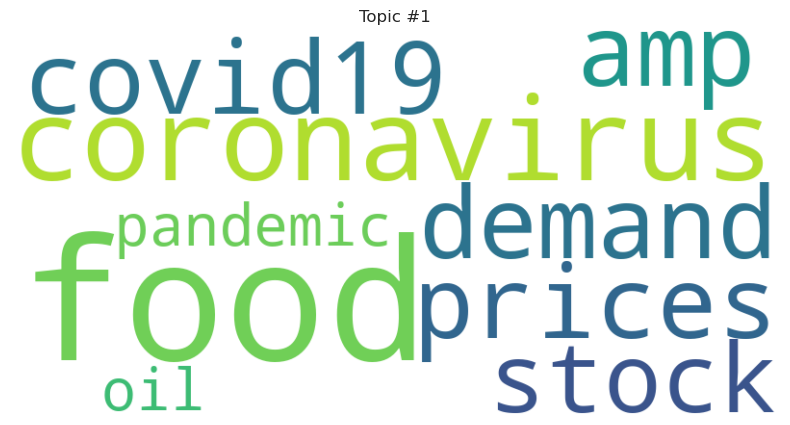

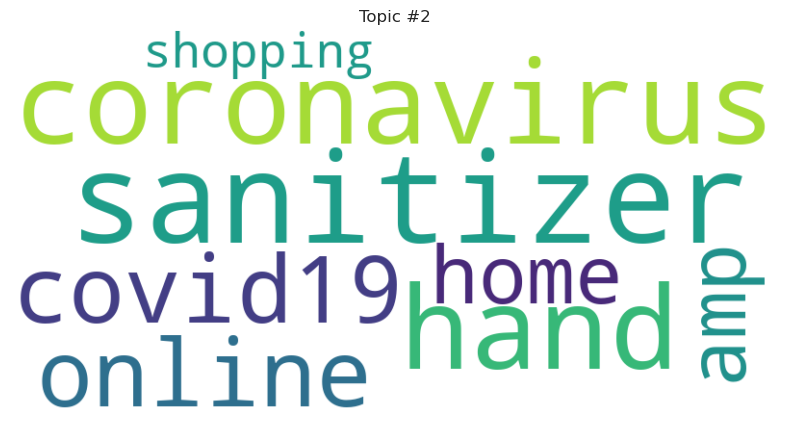

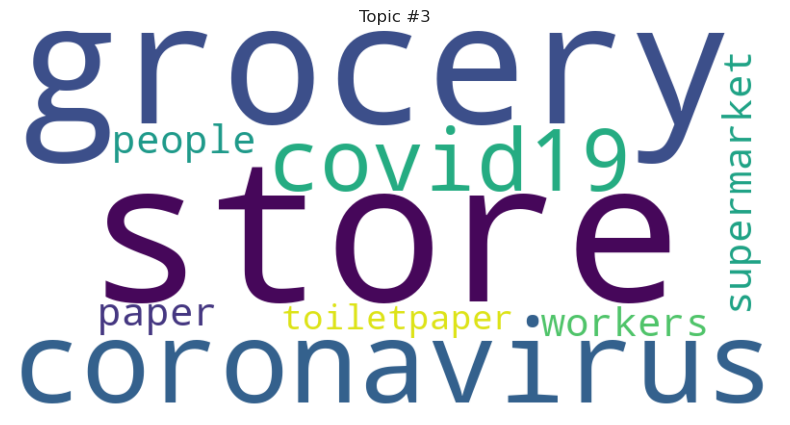

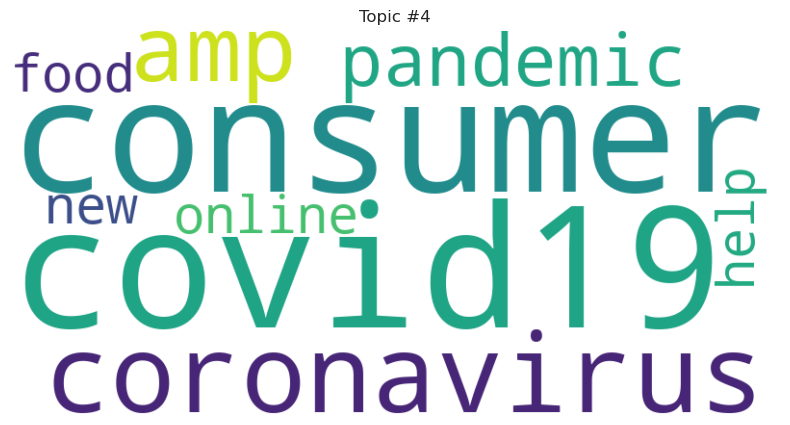

In [25]:
#plot word clouds
def plot_word_clouds(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out() 
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(topic_words))

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic #{topic_idx+1}")
        plt.axis('off')
        plt.show()

plot_word_clouds(lda, count_vectorizer, number_words)

_Now let's try if the two subsets as mentioned in the sentiment analysis have any difference in topics._

In [26]:
#subset1
lda1 = LDA(n_components=number_topics, n_jobs=-1)
lda1.fit(count_vectorizer.fit_transform(subset1['CleanTweet']))
print_topics(lda1, count_vectorizer, number_words)


Topic #1:
coronavirus covid19 prices sanitizer hand help stock gas amp

Topic #2:
store grocery covid19 food coronavirus workers people stores amp

Topic #3:
covid19 coronavirus consumer paper toilet grocery food store toiletpaper

Topic #4:
coronavirus store covid19 grocery amp home people supermarket consumer


In [27]:
#subset2
lda2 = LDA(n_components=number_topics, n_jobs=-1)
lda2.fit(count_vectorizer.fit_transform(subset2['CleanTweet']))
print_topics(lda2, count_vectorizer, number_words)


Topic #1:
coronavirus covid19 store grocery prices food toiletpaper paper workers

Topic #2:
covid19 coronavirus food store grocery prices consumer amp demand

Topic #3:
coronavirus covid19 sanitizer store grocery hand shopping online amp

Topic #4:
covid19 consumer coronavirus prices pandemic scams gas impact information



_We see that there is not any distinct topic in either subset, so we can proceed with the whole dataset._

In [28]:
# Visualize the topics for the whole set

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda.transform(count_data)):
    topic_weights.append([w for i, w in enumerate(row_list)])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=3, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12966 samples in 0.005s...
[t-SNE] Computed neighbors for 12966 samples in 0.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12966
[t-SNE] Computed conditional probabilities for sample 2000 / 12966
[t-SNE] Computed conditional probabilities for sample 3000 / 12966
[t-SNE] Computed conditional probabilities for sample 4000 / 12966
[t-SNE] Computed conditional probabilities for sample 5000 / 12966
[t-SNE] Computed conditional probabilities for sample 6000 / 12966
[t-SNE] Computed conditional probabilities for sample 7000 / 12966
[t-SNE] Computed conditional probabilities for sample 8000 / 12966
[t-SNE] Computed conditional probabilities for sample 9000 / 12966
[t-SNE] Computed conditional probabilities for sample 10000 / 12966
[t-SNE] Computed conditional probabilities for sample 11000 / 12966
[t-SNE] Computed conditional probabilities for sample 12000 / 12966
[t-SNE] Computed conditional probabilities for sam

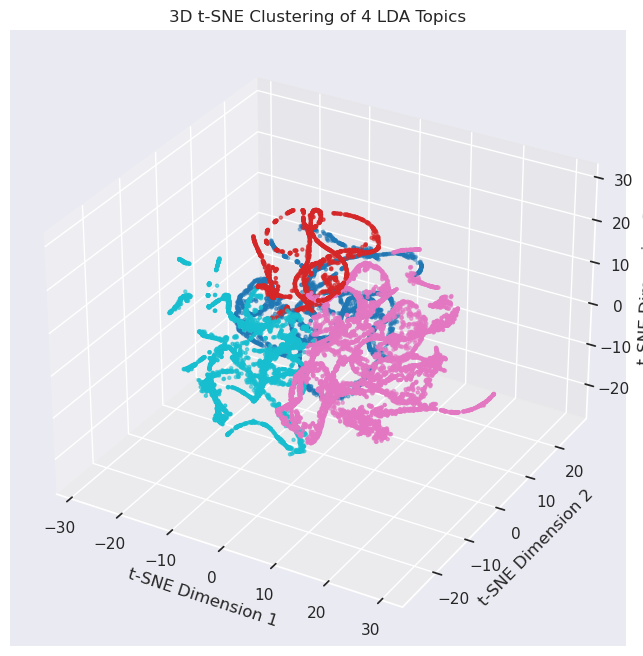

In [29]:
# Plot the Topic Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter(tsne_lda[:,0], tsne_lda[:,1], tsne_lda[:,2], c=topic_num, cmap='tab10', s=5)

# Set labels and title
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.set_title('3D t-SNE Clustering of {} LDA Topics'.format(number_topics))

# Show the plot
plt.show()

## Results/Findings

### 1. Sentiment Analysis
From the results of the sentiment analysis, we first observed that for 86.05% of the days in this dataset, the positive sentiment probability outweighs negative sentiment probability. This implies that the general sentiment of the target audience was positive.

Then, we found out that the tweets' time distribution does not follow the common expectation of uniform distribution; instead, it actually has a bimodal distribution with the peaks at 03/29/2020 and 04/08/2020. To accommodate this distribution, we used two linear regressions for the two groups. We discovered that the sentiment compound scores for both groups have upward trends. The compound score takes into account the intensity and polarity of each token's sentiment and provides an aggregated score for the text, and a higher compound score indicates a more positive sentiment. Thus, from the scatterplots with best-fit lines, the fact that the lines are majority near and above zero with upward trend suggests that the sentiment of the tweets in the United States during the period of March 2nd to April 20th of 2020 have a momentum of changing from neutral to positive.

### 2.Topic Modelling
From the results of the topic analysis, we found that the two subsets do not have significant differences in topics, so we can conclude that the major topics people in the United States tweets during early 2020 are:

- Topic #1:
**store** coronavirus covid19 grocery workers amp employees people retail

- Topic #2:
**food** coronavirus covid19 online shopping amp demand stock panic

- Topic #3:
**covid19** consumer coronavirus prices pandemic amp crisis scams oil

- Topic #4:
**coronavirus** covid19 store grocery people prices sanitizer paper hand

Top keywords for each topic are in bold, and more detailed rankings of keywords are shown by the word cloud plots. These topics align with our intuitive thoughts about the main topics people talk about during the beginning of COVID-19. Meanwhile, we noted some identical keywords across the topics: covid19, coronavirus, food, store, and consumer. This may suggest overlapping or hierarchical topics.

From the t-SNE method, we first observed a low KL divergence value, 0.58 after 1000 iterations, which indicates a stronger alignment between the high-dimensional and low-dimensional distributions. This implies that the t-SNE algorithm has effectively captured the local relationships within the data and preserved its underlying structure in the lower-dimensional space. 

Looking at the t-SNE clustering plots, the separations between clusters are visible but with some overlapping. This indicates that the t-SNE algorithm has captured the main boundaries between topics, while some data points share similar characteristics or feature distributions, indicating potential ambiguity or similarity between the topics. Also, we observed an octopus-like shape for each group in the t-SNE clustering plot, which indicates a high degree of interconnectivity between topics. To be more specific, the data points within each group may have multiple subgroups or variations, and indicates that the relationships between data points within each group are not linear. This aligns with the fact that there are identical keywords across the topics.

## Contribution
We would like to recognize the contributions of all group members as equal.